# Analysis 1: Team Spacing & Positioning (The "Double Commit" Theory)

## 1. Hypothesis
**"Winning teams maintain a significantly wider average distance between teammates compared to losing teams."**

* **Rationale:** In Rocket League, maintaining proper spacing is critical for field coverage. When teammates are too close ("double committing"), they leave large sections of the field open for the opponent to score. We hypothesize that higher spacing correlates with better field control and, consequently, a higher win rate.

## 2. Methodology
To test this, we utilized the high-frequency physics data from the Kaggle `frames.parquet` dataset.

1.  **Metric Calculation (Euclidean Distance):**
    For every frame $t$ in a match, we calculated the 3D Euclidean distance between all pairs of teammates on a specific team:
    $$D(p_1, p_2) = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2 + (z_2-z_1)^2}$$
    We computed the average spacing for the team as:
    $$\text{Spacing}_{\text{team}} = \frac{D(p_1, p_2) + D(p_2, p_3) + D(p_1, p_3)}{3}$$

2.  **Aggregation:**
    We aggregated these frame-by-frame values to derive a single **Mean Spacing** value for every team in every game.

3.  **Statistical Test:**
    We divided the dataset into **Winning Teams** and **Losing Teams** and performed an **Independent Two-Sample T-Test** to determine if the difference in their average spacing was statistically significant ($p < 0.05$).

## 3. Data Enrichment
We further enriched this analysis by merging the match data with **Liquipedia RLCS Rankings**. This allows us to investigate if "Pro" teams (ranked teams) exhibit consistently different spacing patterns compared to unranked or lower-tier teams found in the dataset.

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from thefuzz import process
from scipy import stats

In [45]:
FRAMES_FILE = "frames.parquet"
GAMES_FILE = "games.parquet"
RANKINGS_FILE = "rl_rankings.csv"


In [46]:
games_df = pd.read_parquet(GAMES_FILE)

In [47]:
games_df.head()

,game_num,game_id,filename,time,region,map,series_game_num,team0_name,team1_name,p0_name,p1_name,p2_name,p3_name,p4_name,p5_name
0,1,567936BA445FB96A0A44D0ACA9E36EB6,Split 1/Europe/Regional 1/1 Group Stage/Group ...,2025-01-10 10:11:04,Europe,Stadium_P,1,100%,SYNERGY,accro,LuiisP,rehzzy,tehqoz,ajg,Dorito
1,2,38EA559B4B0B4A4C63D3BDBE60F0E56E,Split 1/Europe/Regional 1/1 Group Stage/Group ...,2025-01-10 10:18:55,Europe,Stadium_P,2,100%,SYNERGY,rehzzy,LuiisP,accro,ajg,tehqoz,Dorito
2,3,A3785E6D43C75FAD6B8A4EB14405BB4D,Split 1/Europe/Regional 1/1 Group Stage/Group ...,2025-01-10 10:25:42,Europe,Stadium_P,3,100%,SYNERGY,LuiisP,rehzzy,accro,ajg,Dorito,tehqoz
3,4,85FB60F1494DC86BFA098CB48F8F2DAA,Split 1/Europe/Regional 1/1 Group Stage/Group ...,2025-01-10 10:33:15,Europe,Stadium_P,4,100%,SYNERGY,accro,rehzzy,LuiisP,Dorito,tehqoz,ajg
4,5,27D5E2B542958145D7AC00B474DA7D33,Split 1/Europe/Regional 1/1 Group Stage/Group ...,2025-01-10 10:44:32,Europe,Stadium_P,5,SYNERGY,100%,tehqoz,ajg,Dorito,LuiisP,rehzzy,accro


In [48]:
cols = ['game_num', 'score_diff']
for i in range(6):
    cols.extend([f'p{i}_pos_x', f'p{i}_pos_y', f'p{i}_pos_z'])


In [49]:
frames_df = pd.read_parquet(FRAMES_FILE, columns=cols)
frames_df[frames_df['game_num']==1]

,game_num,score_diff,p0_pos_x,p0_pos_y,p0_pos_z,p1_pos_x,p1_pos_y,p1_pos_z,p2_pos_x,p2_pos_y,p2_pos_z,p3_pos_x,p3_pos_y,p3_pos_z,p4_pos_x,p4_pos_y,p4_pos_z,p5_pos_x,p5_pos_y,p5_pos_z
1819865,1,0,25.735998,-73.862000,10.516001,-1.210000,-260.548004,3.306,414.025970,-870.200012,3.402000,-21.910002,82.064003,9.484000,-5.214000,355.889984,3.328,-503.464020,805.600037,6.128
1819866,1,0,-1.090000,-32.998001,17.910002,1.274000,-229.293991,3.382,465.660004,-885.596008,3.402000,0.818000,39.198002,14.942000,-8.294001,311.910004,3.360,-533.049988,812.966003,3.220
1819867,1,0,-10.998000,-29.792002,25.158001,7.432000,-169.860001,3.398,494.149994,-888.757996,3.402000,10.418000,36.546001,17.948000,-11.040000,281.600006,3.398,-591.202026,817.476013,3.386
1819868,1,0,-29.407999,-30.528000,28.892002,6.898000,-131.452011,3.398,534.489990,-887.305969,3.402000,16.160002,37.404003,17.730001,-17.198000,250.436020,3.400,-619.846008,810.481995,3.406
1819869,1,0,-39.512001,-30.782001,28.606001,3.108000,-91.752007,3.398,554.804016,-882.962036,3.402000,25.034000,38.730000,17.288000,-26.268000,218.501999,3.400,-643.142029,796.383972,3.406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823429,1,0,-236.162018,400.786011,3.400000,191.746002,594.794006,3.402,-55.134003,821.594055,59.756001,-31.851999,789.966003,63.318001,-718.360046,-61.259998,3.312,8.422000,481.574036,3.398
1823430,1,0,-262.706024,430.394012,3.400000,169.371994,625.898010,3.402,-66.564003,841.934021,57.070004,-54.964001,784.256042,63.084003,-716.690002,-19.246000,3.388,8.290000,523.549988,3.398
1823431,1,0,-279.372009,453.064026,3.400000,158.018005,646.539978,3.402,-90.694000,884.874023,49.004002,-103.756004,772.204041,62.590004,-715.351990,11.506000,3.398,8.086000,588.422058,3.398
1823432,1,0,-290.269989,471.070038,3.400000,150.480011,663.239990,3.402,-105.933998,911.994080,42.236000,-129.436005,765.862000,62.278004,-712.932007,92.036003,3.398,7.682000,626.566040,3.398


In [50]:
# ==========================================
# 2. FEATURE ENGINEERING: TEAM SPACING
# ==========================================
def get_team_avg_spacing(df, p_indices):
    """
    Calculates the average distance between 3 players (A-B, B-C, A-C).
    p_indices: list of player numbers [0,1,2] or [3,4,5]
    """
    p1, p2, p3 = p_indices
    
    # Extract coordinates
    # We use numpy arrays for fast vector subtraction
    v1 = df[[f'p{p1}_pos_x', f'p{p1}_pos_y', f'p{p1}_pos_z']].values
    v2 = df[[f'p{p2}_pos_x', f'p{p2}_pos_y', f'p{p2}_pos_z']].values
    v3 = df[[f'p{p3}_pos_x', f'p{p3}_pos_y', f'p{p3}_pos_z']].values
    
    # Calculate Distances (Euclidean)
    dist_1_2 = np.linalg.norm(v1 - v2, axis=1)
    dist_2_3 = np.linalg.norm(v2 - v3, axis=1)
    dist_1_3 = np.linalg.norm(v1 - v3, axis=1)
    
    # Average distance for the team
    return (dist_1_2 + dist_2_3 + dist_1_3) / 3


In [51]:
frames_df['team0_spacing'] = get_team_avg_spacing(frames_df, [0, 1, 2])
frames_df['team1_spacing'] = get_team_avg_spacing(frames_df, [3, 4, 5])

In [52]:
frames_df[frames_df['game_num']==1]

,game_num,score_diff,p0_pos_x,p0_pos_y,p0_pos_z,p1_pos_x,p1_pos_y,p1_pos_z,p2_pos_x,p2_pos_y,...,p3_pos_y,p3_pos_z,p4_pos_x,p4_pos_y,p4_pos_z,p5_pos_x,p5_pos_y,p5_pos_z,team0_spacing,team1_spacing
1819865,1,0,25.735998,-73.862000,10.516001,-1.210000,-260.548004,3.306,414.025970,-870.200012,...,82.064003,9.484000,-5.214000,355.889984,3.328,-503.464020,805.600037,6.128,604.125000,604.913269
1819866,1,0,-1.090000,-32.998001,17.910002,1.274000,-229.293991,3.382,465.660004,-885.596008,...,39.198002,14.942000,-8.294001,311.910004,3.360,-533.049988,812.966003,3.220,657.644836,646.268494
1819867,1,0,-10.998000,-29.792002,25.158001,7.432000,-169.860001,3.398,494.149994,-888.757996,...,36.546001,17.948000,-11.040000,281.600006,3.398,-591.202026,817.476013,3.386,669.278381,674.035522
1819868,1,0,-29.407999,-30.528000,28.892002,6.898000,-131.452011,3.398,534.489990,-887.305969,...,37.404003,17.730001,-17.198000,250.436020,3.400,-619.846008,810.481995,3.406,686.009949,679.994202
1819869,1,0,-39.512001,-30.782001,28.606001,3.108000,-91.752007,3.398,554.804016,-882.962036,...,38.730000,17.288000,-26.268000,218.501999,3.400,-643.142029,796.383972,3.406,694.122009,681.008850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823429,1,0,-236.162018,400.786011,3.400000,191.746002,594.794006,3.402,-55.134003,821.594055,...,789.966003,63.318001,-718.360046,-61.259998,3.312,8.422000,481.574036,3.398,423.776367,773.021912
1823430,1,0,-262.706024,430.394012,3.400000,169.371994,625.898010,3.402,-66.564003,841.934021,...,784.256042,63.084003,-716.690002,-19.246000,3.388,8.290000,523.549988,3.398,419.220795,741.037659
1823431,1,0,-279.372009,453.064026,3.400000,158.018005,646.539978,3.402,-90.694000,884.874023,...,772.204041,62.590004,-715.351990,11.506000,3.398,8.086000,588.422058,3.398,433.060394,708.767578
1823432,1,0,-290.269989,471.070038,3.400000,150.480011,663.239990,3.402,-105.933998,911.994080,...,765.862000,62.278004,-712.932007,92.036003,3.398,7.682000,626.566040,3.398,439.885468,664.884277


In [53]:
games_df[games_df['game_num']==1]

,game_num,game_id,filename,time,region,map,series_game_num,team0_name,team1_name,p0_name,p1_name,p2_name,p3_name,p4_name,p5_name
0,1,567936BA445FB96A0A44D0ACA9E36EB6,Split 1/Europe/Regional 1/1 Group Stage/Group ...,2025-01-10 10:11:04,Europe,Stadium_P,1,100%,SYNERGY,accro,LuiisP,rehzzy,tehqoz,ajg,Dorito


In [54]:
game_stats = frames_df.groupby('game_num').agg({
    'team0_spacing': 'mean',
    'team1_spacing': 'mean',
    'score_diff': 'last'
}).reset_index()
game_stats.head()

,game_num,team0_spacing,team1_spacing,score_diff
0,1,736.891602,700.344360,0
1,2,732.812378,719.664490,-2
2,3,739.846008,714.006409,-1
3,4,808.264404,691.663147,3
4,5,682.684143,742.841370,-2


```
game_num : Game number, not unique in frames_df
score_diff : Current score calculated by team0_score-team1_score, selected last meaning the last frame of the game.
team{x}_spacing : Avg spacing between teammates. Calc-ed using linalg.norm
```

In [55]:
game_stats['winner'] = game_stats['score_diff'].apply(
    lambda x: 'Team 0' if x > 0 else ('Team 1' if x < 0 else 'Draw')
)
game_stats = game_stats[game_stats['winner'] != 'Draw'] # Filter out all draws, as they might corrupt the analysis.
game_stats.head()

,game_num,team0_spacing,team1_spacing,score_diff,winner
1,2,732.812378,719.664490,-2,Team 1
2,3,739.846008,714.006409,-1,Team 1
3,4,808.264404,691.663147,3,Team 0
4,5,682.684143,742.841370,-2,Team 1
5,6,758.911926,731.418701,1,Team 0


In [56]:
full_game_data = pd.merge(
    game_stats, 
    games_df[['game_num', 'team0_name', 'team1_name']], 
    on='game_num'
)

team0_rows = full_game_data[['team0_name', 'team0_spacing', 'winner']].copy()
team0_rows['won'] = (team0_rows['winner'] == 'Team 0').astype(int)
team0_rows.rename(columns={'team0_name': 'team_name', 'team0_spacing': 'avg_spacing'}, inplace=True)

team1_rows = full_game_data[['team1_name', 'team1_spacing', 'winner']].copy()
team1_rows['won'] = (team1_rows['winner'] == 'Team 1').astype(int)
team1_rows.rename(columns={'team1_name': 'team_name', 'team1_spacing': 'avg_spacing'}, inplace=True)

final_df = pd.concat([team0_rows, team1_rows], ignore_index=True)
final_df = final_df[['team_name', 'avg_spacing', 'won']]

final_df

,team_name,avg_spacing,won
0,100%,732.812378,0
1,100%,739.846008,0
2,100%,808.264404,1
3,SYNERGY,682.684143,0
4,KARMINE CORP,758.911926,1
...,...,...,...
2993,NRG ESPORTS,733.409973,1
2994,NRG ESPORTS,718.843567,1
2995,NRG ESPORTS,775.502808,0
2996,NRG ESPORTS,706.046265,1


### Merge with liquipedia:

In [57]:
rankings = pd.read_csv(RANKINGS_FILE)
rankings.head()

,Team,Points,Region
0,Virtus.pro,109,APAC
1,Movistar KOI,66,APAC
2,Dreamstation,43,APAC
3,KINOTROPE gaming,37,APAC
4,God Speed,27,APAC


In [58]:
unique_teams = final_df['team_name'].unique()
unique_teams

array(['100%', 'SYNERGY', 'KARMINE CORP', 'RRG', 'SAVE THE GAME',
       'NOVO ESPORTS', 'REDEMPTION', 'GEEKAY ESPORTS', None, 'M8 ALPINE',
       'NIP', 'ASCEND', 'SELECAO', 'TEAM VITALITY', 'GK ESPORTS',
       'TEAM G.A.S.', '9LIVES', 'DELETED GAMING', 'PIRATES ',
       'ALMOST NUTS', 'PIRATES', 'TECH', 'STRICTLY BUSINES', 'DELETED',
       'COMPLEXITY', 'STRICTLY', 'REBELLION', 'SHOPIFY', 'GEN.G MOBIL1',
       'STRICTLY BIZ', 'SPACESTATION', 'G.A.S.', 'OMELETTE',
       'GEN.G MOBIL 1', 'TEAM EVO', 'ULTIMATES', 'NOMSTER', 'STARTPOINT',
       'WASSUP', 'TREE LAMP', 'THE WOO', 'NAC', 'THE ULTIMATES',
       'CALIENTE', 'TEAM JJROX', 'F4WD', 'GENG MOBIL 1', 'LOTUS 8',
       'HELFIE CHIEFS', 'GENG MOBIL1', 'TWISTED MINDS', 'LUMINOSITY',
       'TEAM FALCONS', 'FURIA', 'WILDCARD', 'TEAM SECRET', 'FUT ESPORTS',
       'NAH', 'SIMTAWK+1', 'POWER RANGERS', 'STRICTLYBIZ', 'PWR RANGERS',
       'DOPAMINE', 'ATOM UNITY', 'TEAM BSK', 'GENTLE MATES', 'TEAM BDS',
       'DANGEROUS', 'KCORP',

In [59]:
lp_teams = rankings['Team'].unique() # Liquipedia teams list
lp_teams

array(['Virtus.pro', 'Movistar KOI', 'Dreamstation', 'KINOTROPE gaming',
       'God Speed', 'Tu-tu-du-du Verstappen', 'Zen Esports', 'ROUNDS',
       'Overlooked', 'Blue Torch', 'Jungle Juicers', "Pxress's Habibtis",
       'SENZA Esports', 'Team Phoenix', 'Crazy boy', 'boba tea', 'sial',
       'ReaL Adrenaline', 'Ex-Overlooked', 'Revenue Redeemers', 'Praise',
       'name', 'AL7ANKALEES', 'Absolute Cinema', 'UHUH', 'VipeRR', '360',
       'Animated Dragons', 'Big Dawgs', 'Error404.', 'Intake Region',
       "Machi's Minions", 'Small Esports', 'TTG', 'Winter Soldiers',
       'Yokohama F. Marinos Esports', 'Karmine Corp', 'Dignitas',
       'Team Vitality', 'Geekay Esports', 'Gentle Mates Alpine',
       'Ninjas in Pyjamas', '100%', 'Synergy', 'F4WD', 'Team BSK',
       'Team BDS', 'Startpoint', 'Redemption', 'Los Leones de Montepinar',
       'CALIENTE', 'RRG', 'Dopamine', 'Save the game', '$ATM',
       'Smokey Bacon Association', 'Chippy Chips', 'Cloud eSport',
       'NOVO Esport

In [60]:
mapping = {}
for team in unique_teams:
    # Get best match. If score > 85, assume it's the same team.
    match, score = process.extractOne(str(team), lp_teams)
    if score > 85:
        mapping[team] = match
    else:
        mapping[team] = None

mapping

{'100%': '100%',
 'SYNERGY': 'Synergy',
 'KARMINE CORP': 'Karmine Corp',
 'RRG': 'RRG',
 'SAVE THE GAME': 'Save the game',
 'NOVO ESPORTS': 'NOVO Esports',
 'REDEMPTION': 'Redemption',
 'GEEKAY ESPORTS': 'Geekay Esports',
 None: None,
 'M8 ALPINE': 'Gentle Mates Alpine',
 'NIP': None,
 'ASCEND': None,
 'SELECAO': None,
 'TEAM VITALITY': 'Team Vitality',
 'GK ESPORTS': 'LUK eSports',
 'TEAM G.A.S.': 'G.A.S.',
 '9LIVES': '9Lives',
 'DELETED GAMING': 'Deleted Gaming',
 'PIRATES ': 'Pirates on a Boat',
 'ALMOST NUTS': None,
 'PIRATES': 'Pirates on a Boat',
 'TECH': 'tech',
 'STRICTLY BUSINES': 'Strictly Business',
 'DELETED': 'Deleted Gaming',
 'COMPLEXITY': 'Complexity Gaming',
 'STRICTLY': 'Strictly Business',
 'REBELLION': 'Shopify Rebellion',
 'SHOPIFY': 'Shopify Rebellion',
 'GEN.G MOBIL1': 'Gen.G Mobil1 Racing',
 'STRICTLY BIZ': None,
 'SPACESTATION': 'Spacestation Gaming',
 'G.A.S.': 'G.A.S.',
 'OMELETTE': 'Omelette',
 'GEN.G MOBIL 1': 'G.A.S.',
 'TEAM EVO': 'Team Evo',
 'ULTIMATES'

In [61]:
final_df['liquipedia_name'] = final_df['team_name'].map(mapping)

In [62]:
final_df.head()

,team_name,avg_spacing,won,liquipedia_name
0,100%,732.812378,0,100%
1,100%,739.846008,0,100%
2,100%,808.264404,1,100%
3,SYNERGY,682.684143,0,Synergy
4,KARMINE CORP,758.911926,1,Karmine Corp


In [93]:
enriched_df = pd.merge(
        final_df,
        rankings[['Team', 'Points']], 
        left_on='liquipedia_name', 
        right_on='Team', 
        how='left'
    )

enriched_df['Points'] = enriched_df['Points'].fillna(0)
enriched_df.head()

,team_name,avg_spacing,won,liquipedia_name,Team,Points
0,100%,732.812378,0,100%,100%,21.0
1,100%,739.846008,0,100%,100%,21.0
2,100%,808.264404,1,100%,100%,21.0
3,SYNERGY,682.684143,0,Synergy,Synergy,12.0
4,KARMINE CORP,758.911926,1,Karmine Corp,Karmine Corp,126.0


### Hypothesis test

#### Test 1: Double commit or Winning vs Spacing

In [101]:
winners_spacing = enriched_df[enriched_df['won'] == 1]['avg_spacing']
losers_spacing = enriched_df[enriched_df['won'] == 0]['avg_spacing']

In [102]:
test = enriched_df[enriched_df['won'] == 1]['avg_spacing']
len(winners_spacing)

1499

In [106]:
t_stat, p_val = stats.ttest_ind(winners_spacing, losers_spacing, nan_policy='omit')

In [107]:
t_stat

np.float64(3.57148092510513)

In [108]:
p_val

np.float64(0.000360568746121311)

In [112]:
print(f"\n[Hypothesis 1] Winners maintain wider spacing?")
print(f"Avg Spacing (Winners): {winners_spacing.mean():.2f}")
print(f"Avg Spacing (Losers):  {losers_spacing.mean():.2f}")
print(f"P-Value: {p_val:.10f}")

if p_val < 0.05:
    print(">> RESULT: Significant! Spacing affects winning.")
else:
    print(">> RESULT: No significant difference.")



[Hypothesis 1] Winners maintain wider spacing?
Avg Spacing (Winners): 746.73
Avg Spacing (Losers):  741.29
P-Value: 0.0003605687
>> RESULT: Significant! Spacing affects winning.


#### Test 2: The Pro Play theory (Ranked vs Unranked)

In [113]:
ranked_spacing = enriched_df[enriched_df['Points'] > 0]['avg_spacing']
unranked_spacing = enriched_df[enriched_df['Points'] == 0]['avg_spacing']

In [117]:
t_stat_2, p_val_2 = stats.ttest_ind(ranked_spacing, unranked_spacing, nan_policy='omit')

In [118]:
t_stat_2

np.float64(0.35054741412755686)

In [119]:
p_val_2

np.float64(0.7259526235355197)

In [123]:
print(f"\n[Hypothesis 2] Do Pro Teams space differently?")
print(f"Avg Spacing (Ranked):   {ranked_spacing.mean():.2f}")
print(f"Avg Spacing (Unranked): {unranked_spacing.mean():.2f}")
print(f"P-Value: {p_val_2:.5f}")

if p_val_2 < 0.05:
    print(">> RESULT: Significantly! Ranked Players do play quite differently.")
else:
    print(">> RESULT: No significant difference.")


[Hypothesis 2] Do Pro Teams space differently?
Avg Spacing (Ranked):   744.10
Avg Spacing (Unranked): 743.23
P-Value: 0.72595
>> RESULT: No significant difference.


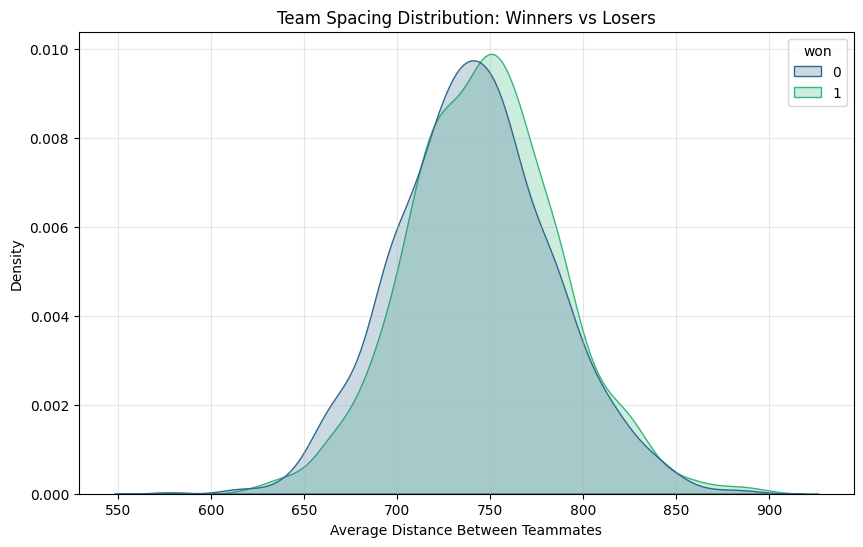

In [128]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=enriched_df, x='avg_spacing', hue='won', fill=True, common_norm=False, palette='viridis')
plt.title("Team Spacing Distribution: Winners vs Losers")
plt.xlabel("Average Distance Between Teammates")
plt.grid(True, alpha=0.3)
plt.savefig("spacing_hypothesis.png")